##### Copyright 2020 Google LLC.


Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Tensorflow modules.
import tensorflow as tf

In [0]:
# Install Tensorflow Lattice and Tensorflow Constrained Optimization libraries.
!pip install tensorflow_lattice
!pip install git+https://github.com/google-research/tensorflow_constrained_optimization

In [0]:
# Tensor flow lattice modules.
import tensorflow_lattice as tfl

# Tensorflow constrained optimization modules.
import tensorflow_constrained_optimization as tfco

## Overview

In this notebook, we'll train a one-dimensional monotonic function with pairwise constraints for fairness.  

**Problem Setup:** We will consider a simulated ranking task consisting of a set of examples represented by real-valued scores $\{x_1, \ldots, x_n\}$ and a set of "ground truth" labels $\{y_1, \ldots, y_n\}$ (with higher implying better). Each example is also associated with a binary protected group. The goal is to learn a real-valued function $f: \mathbb{R} \rightarrow \mathbb{R}$ on the scores that ranks examples with higher labels above those with lower labels.  Additionally, we will impose a fairness goal on $f$ (loosely speaking, we will require $f$ to perform equally well on examples from both groups). 
<br><br>

**Pairwise Fairness:** For measuring fairness, we will adopt the "pairwise" fairness criteria proposed in:
> Harikrishna Narasimhan, Andrew Cotter, Maya Gupta, Serena Wang, "Pairwise Fairness for Ranking and Regression", AAAI 2020.

Henceforth, we will refer to this paper as [NCGW19].
<br><br>

The fairness criteria in [NCGW19] are defined in terms of the group-dependent pairwise accuracy for $f$:
$$
Acc_{G_i > G_j}(f) \,=\, \mathbb{P}( f(x) > f(x') \mid y > y', (x,y) \in G_i, (x',y') \in G_j ).
$$
We will use a slight variant of the above definition that assigns a value of 1/2 for ties:
$$
Acc_{G_i > G_j}(f) \,=\, \mathbb{P}( f(x) > f(x') \mid y > y', (x,y) \in G_i, (x',y') \in G_j ) \,+\, 
\frac{1}{2}\mathbb{P}( f(x) = f(x') \mid y > y', (x,y) \in G_i, (x',y') \in G_j ).
$$

We will also be interested in the  overall pairwise accuracy of $f$:
$$
A(f) \,=\, \mathbb{P}( f(x) > f(x') \mid y > y' ) \,+\, \frac{1}{2}\mathbb{P}( f(x) = f(x') \mid y > y' ).
$$
<br>

**Monotone Function**: We will restrict our attention to ranking functions $f$ that are monotonic in the scores $x$. While the learned monotone function cannot change the underlying ordering of examples , it can introduce ties in the ordering. As we will see, this can be helpful in enforcing our fairness goal. 

Throughout this notebook, we will refer to the $x$ as the original score for an example, and $f(x)$ as the prediction for the example.


## Simulated Data

We generate a dataset with two groups. We generate the scores in such a way that they are more accurate for one of the groups.

In [0]:
np.random.seed(123456)

# Generate 100 examples. Each example has a score, label and a binary group.
num_examples = 100

# Generate labels from a uniform distribution, and 
# the associated protected groups from a Bernoulli(0.5).
labels = np.random.rand(num_examples)
groups = (np.random.rand(num_examples) > 0.5) * 1

# Generate scores by introducing Gaussian noise in the labels, 
# and scale them  to [0, 1].
scores = labels + np.random.normal(loc=0, scale=0.05, size=num_examples)
scores = (scores - scores.min()) / (scores.max() - scores.min())

# Additional noise for group 1 examples.
# Add uniform random noise to the group scores in the range [0.2, 0.8].
noise_low = 0.2
noise_high = 0.8
noise_indices = (groups == 1) & (scores >= noise_low) & (scores <= noise_high)
scores[noise_indices] = noise_low + (
    np.random.rand(sum(noise_indices)) * (noise_high - noise_low))

Let us plot the generated data.

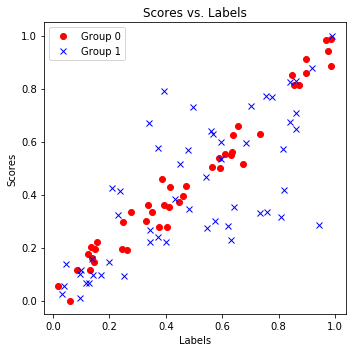

In [5]:
def plot_scores(x, y, groups, ax, xlabel, ylabel):
  # Plots x vs. y using different markers for the group0 and group1 examples.
  ax.plot(x[groups == 0], y[groups == 0], "ro", label="Group 0")
  ax.plot(x[groups == 1], y[groups == 1], "bx", label="Group 1")
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.set_title(ylabel + " vs. " + xlabel)
  ax.legend(loc="best")
  ff.tight_layout()
  
# Plot scores as a function of labels.
ff, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_scores(labels, scores, groups, ax, "Labels", "Scores")

Notice that the original scores order the group 0 examples accurately, but are unreliable for the group 1 examples in the range [0.2, 0.8]. 
Can we learn a monotone transform on these scores that performs equally well on both groups? For example, would we be able to improve the performance on the group 1 examples by flattening the scores in the [0.2, 0.8] range, while preserving their relative ordering in other regions?

## Formulate Pairs

Having generated the data, we enumerate all pairs of examples $(x, x')$ where the labels $y > y'$. By creating ordered example pairs, we can now treat the ranking problem as a classification problem on pairs. 

In [0]:
# Create a pandas DataFrame with the data contents.
examples_df = pd.DataFrame()
examples_df = examples_df.assign(scores=scores, labels=labels, groups=groups, 
                                 merge_key=0)

# We have an additional merge_key column, which we will use to merge the 
# data frame with itself, and enumerate all pairs of examples.
paired_df = examples_df.merge(examples_df.copy(), on="merge_key", how="outer",
                              suffixes=("_high", "_low"))

# Only retain pairs where labels_high > labels_low.
paired_df = paired_df[paired_df.labels_high > paired_df.labels_low]

# Create 2-d NumPy array containing the scores for the higher label examples
# in the first column and the scores for lower label examples in the second 
# column. Similarly, create a 2-d NumPy array for the groups.
paired_scores = np.stack([paired_df.scores_high.values, 
                          paired_df.scores_low.values], axis=1)
paired_labels = np.stack([paired_df.labels_high.values, 
                          paired_df.labels_low.values], axis=1)
paired_groups = np.stack([paired_df.groups_high.values, 
                          paired_df.groups_low.values], axis=1)

Note that `paired_scores`  and `paired_groups` are two-dimensional arrays, where each row represents an ordered pair of example.  The first column in `paired_scores`  contains the scores for the 'high label' examples in the pairs, and the second column contains the scores for the 'low label' examples in the pairs. Similarly,  `paired_groups` contains the corresponding protected groups for the 'high label' and 'low label' examples in the pairs.

## Monotone Model

We next model the ranking function $f$ as a monotone, one-dimensional calibrator. We use the callibration layer provided in the TF Lattice package to construct the monotone function, and compute the difference in function values $f(x) - f(x')$ on each pair of examples $(x, x')$. The pairwise accuracies can then be computed as a classification rates on the differences in scores.

For more details on 1-D calibrators, please see the following <a href="http://jmlr.org/papers/v17/15-243.html"> paper</a>.

In [0]:
tf.reset_default_graph()

# We 1-d callibrator with 100 key points. A monotone function is constructed by
# linearly interpolating the values on these keypoints.
num_keypoints = 100
kp_inits = tfl.uniform_keypoints_for_signal(
    num_keypoints=num_keypoints,
    input_min=0.0,
    input_max=1.0,
    output_min=0,
    output_max=1.0)

# Placeholder tensor for holding the input scores.
scores_tensor = tf.placeholder(tf.float32, shape=(None,), name="scores")
# We pass 1-d input array to the calibrator. Recall that we will eventually need
# to compute scores on pairs of examples (x, x'), i.e. on the paired_scores
# array. To do so, we will flatten paired_scores and 
# pass it as a 1-d array (where the first half contains the "x" scores, and the 
# second half contains the "x'" scores).

# Predictions from the calibrator on the input scores.
(predictions_tensor, projection_op, _) = tfl.calibration_layer(
    uncalibrated_tensor=scores_tensor,
    num_keypoints=num_keypoints,
    monotonic=+1,
    keypoints_initializers=kp_inits)
# Setting monotonic=+1 enforces that the calibrator is monotonic.
# Note that the returned projection_op is the projection operation for 
# enforcing monotonicity.

# Since we will feed in a flattened array of scores as input, the 
# predictions_tensor will also be one dimensional. The first half of this tensor 
# will contain the scores for the "x" examples and the second half of the tensor 
# will contain the scores for the "x'" examples. We will slice the 
# predictions_tensor into two halves and compute the element-wise differences 
# in scores between the first half and the second half, i.e. f(x) - f(x').
num_pairs = tf.cast(tf.shape(scores_tensor)[0] / 2, tf.int32)
prediction_diffs_tensor = (predictions_tensor[:num_pairs] - 
                           predictions_tensor[num_pairs:])

By creating ordered pairs of examples $(x, x')$, we can now frame the ranking problem as a classification task, with the goal of maximizing the fraction of examples where the difference  $f(x) - f(x')$ is positive. To this end, we define an all 1's tensor that holds the target label for each pair.



In [0]:
target_labels_tensor = tf.ones(dtype=tf.float32, shape=(num_pairs,), 
                               name="target_labels")

We will also need placeholder tensors to identify subsets of example pairs on which we wish to impose fairness constraints. For this tutorial, we will impose constraints on two subsets of example pairs. We create tensors for holding boolean predicates for identifying these subsets.

In [0]:
subset0_predicate = tf.placeholder(tf.bool, shape=(None,), name="subset0")
subset1_predicate = tf.placeholder(tf.bool, shape=(None,), name="subset1")

## Baseline: Original Scores

Before proceeding to train our model, let us first evaluate the performance of the original, untransformed scores.
Below, we provide functions for evaluating the group-dependent pairwise accuracy and the overall accuracy for given the score differences on pairs of examples.

In [0]:
def group_pairwise_accuracy(prediction_diffs, paired_groups):
  """Returns the group-dependent pairwise accuracies.
  
  Returns the group-dependent pairwise accuracies Acc_{G_i > G_j} for each pair 
  of groups G_i \in {0, 1} and G_j \in {0, 1}. 
  
  Args:
    prediction_diffs: NumPy array of shape (#num_pairs,) containing the 
                      differences in scores for each ordered pair of examples.
    paired_groups: NumPy array of shape (#num_pairs, 2) containing the protected 
                   groups for the better and worse example in each pair.
                   
  Returns:
    A NumPy array of shape (2, 2) containing the pairwise accuracies, where the 
    ij-th entry contains Acc_{G_i > G_j}.
  """
  accuracy_matrix = np.zeros((2, 2))
  for group_high in [0, 1]:
    for group_low in [0, 1]:
      # Predicate for pairs where the better example is from group_high
      # and the worse example is from group_low.
      predicate = ((paired_groups[:, 0] == group_high) & 
                   (paired_groups[:, 1] == group_low))
      # Parwise accuracy Acc_{group_high > group_low}.
      accuracy_matrix[group_high][group_low] = (
          np.mean(prediction_diffs[predicate] > 0) + 
          0.5 * np.mean(prediction_diffs[predicate] == 0))
  return accuracy_matrix


def overall_pairwise_accuracy(prediction_diffs):
  # Returns overall pairwise accuracy for pairwise differences in predictions.
  overall_accuracy = (np.mean(prediction_diffs > 0) + 
                      0.5 * np.mean(prediction_diffs == 0))
  return overall_accuracy

We evaluate the performance of ranking with the original scores.

In [23]:
prediction_diffs = paired_scores[:, 0] - paired_scores[:, 1]
overall_accuracy = overall_pairwise_accuracy(prediction_diffs)
print("Baseline: Overall pairwise accuracy = %.3f" % overall_accuracy)

pairwise_accuracy = group_pairwise_accuracy(prediction_diffs, paired_groups)
print("Baseline: Group-dependent pairwise accuracies"
      "(rows=better, columns=worse)")
pairwise_accuracy_df = pd.DataFrame(
    pairwise_accuracy, 
    columns=["Group 0", "Group 1"], 
    index=["Group 0", "Group 1"]).round(decimals=3)
print(pairwise_accuracy_df)

Baseline: Overall pairwise accuracy = 0.840
Baseline: Group-dependent pairwise accuracies(rows=better, columns=worse)
         Group 0  Group 1
Group 0    0.938    0.886
Group 1    0.794    0.777


Note that $Acc_{G0 > G1}$ is significantly higher than $Acc_{G1 > G0}$. This implies that the original scores are more effective in ranking the "better" examples from group 0 above the "worse" examples from group 1, when compared to ranking the "better" examples from group 1 above the worse examples from group 0.

In the following, we will seek to remove this discrepancy by learning a monotone function on the scores under pairwise constraints for fairness.

## Proposed Approach: Constrained Optimization

We seek to maximize the overall pairwise accuracy subject to the constraint that $Acc_{G1 > G0}$ and $Acc_{G0 > G1}$ can differ by at most 0.01.

$$
max_f ~~A(f) ~~~~s.t.~~~~ |Acc_{G1 > G0}(f)   ~-~ Acc_{G0 > G1}(f)| ~\leq~ 0.01
$$

The constraint that we enforce here is a relaxation of the *cross-group pairwise equal opportunity* criteria in [NCGW19].

In [0]:
# We set up the constrained optimization problem using the TF constrained 
# optimization library. 

# Set up context object for the entire data 
# (for evaluating performance based on the pairwise prediction differences and 
# and the target labels).
context_overall = tfco.rate_context(prediction_diffs_tensor, 
                                    target_labels_tensor)
# Set up context objects for the subsets: 
# G0>G1 pairs denoted as subset0 and G1>G0 pairs denoted as subset1.
context_subset0 = context_overall.subset(subset0_predicate)
context_subset1 = context_overall.subset(subset1_predicate)
# The subset predicates will be fed in during training.

# Set up the objective and constraints in terms of error rates.
# (while the definitions in the notebook used "accuracy rates", we will find
# it convenient in the implementation to instead use "error rates")
# The objective is to minimize the error rate on all pairs.
objective = tfco.error_rate(context_overall)
# Since the target labels are all 1's, minimizing the error rate on the 
# prediction differences is the same as maximizing overall pairwise accuracy.
constraints = [
    tfco.error_rate(context_subset0) <= tfco.error_rate(context_subset1) + 0.01,
    tfco.error_rate(context_subset1) <= tfco.error_rate(context_subset0) + 0.01]
# We constrain the difference between the error rate on the G0>G1 pairs and the
# error rate on the G1>G0 pairs to be within 0.01
# (this is equivalent to constraining the accuracy rates on the two subsets).

# Set up a rate minimization problem.
problem = tfco.RateMinimizationProblem(objective, constraints)

# Set up the optimizer and get `train_op` for gradient updates.
solver = tf.train.AdamOptimizer(learning_rate=0.1)
optimizer = tfco.ProxyLagrangianOptimizerV1(optimizer=solver)
train_op = optimizer.minimize(problem)

We are now ready to train our model (this may take a few seconds to run).

In [27]:
# Start TF session and initialize variables.
session = tf.Session()
tf.set_random_seed(654321)  # Set random seed for reproducibility.
session.run(tf.global_variables_initializer())

# Dictionary of values to be fed to the placeholder tensors.
feed_dict = {
    scores_tensor: paired_scores.T.reshape(-1,),
    subset0_predicate: (paired_groups[:, 0] == 0) & (paired_groups[:, 1] == 1),
    subset1_predicate: (paired_groups[:, 0] == 1) & (paired_groups[:, 1] == 0)
}
# Scores: As mentioned earlier, we flatten the paired_scores so that the scores 
# for the higher label (better) examples in the pairs are arranged first, and 
# those for the lower label (worse) examples in the pairs come next.
# Predicates: subset0_predicate select pairs where the better example
# is from group 0 and the worse example is from group 1. subset1_predicate 
# select pairs where the better example is from group 1 and the worse
# example is from group 0.

# We maintain a list of objectives, constraint violations, predictions and 
# overall accuracies, and pairwise accuracies during the course of training.
objectives = []
violations = []
predictions = []
overall_accuracies = []
pairwise_accuracies = []

# Perform 250 full gradient updates.
for ii in range(250):
  # Gradient updates.
  session.run(train_op, feed_dict=feed_dict)
  # Projection step.
  session.run(projection_op)
  # Checkpoint once in 10 iterations.
  if ii % 10 == 0:
    # Objective and constraint violations.
    objective, violation = session.run(
        (problem.objective(), problem.constraints()), feed_dict=feed_dict)
    objectives.append(objective)
    violations.append(violation)
    
    # Pairwise prediction differences and overall and group pairwise accuracies.
    prediction_diffs = session.run(
        prediction_diffs_tensor, 
        feed_dict={scores_tensor: paired_scores.T.reshape(-1,)}) 
    # Note that we feed in the "paired" scores, flattened to a 1-d array.
    overall_acc = overall_pairwise_accuracy(prediction_diffs)
    overall_accuracies.append(overall_acc)
    pairwise_acc = group_pairwise_accuracy(prediction_diffs, paired_groups)
    pairwise_accuracies.append(pairwise_acc)
    
    # Predictions on individual examples 
    # (needed later for plotting the trained monotone function).
    prediction = session.run(predictions_tensor, 
                             feed_dict={scores_tensor: scores})
    # Note that we feed in the individual scores (not the paired ones).
    predictions.append(prediction)
    
session.close()
    
# Use the recorded objectives and constraints to find the best iterate.
best_iterate = tfco.find_best_candidate_index(np.array(objectives),
                                              np.array(violations))

print("Constrained Opt: Overall pairwise accuracy = %.3f" 
      % overall_accuracies[best_iterate])
print("Constrained Opt: Group-dependent pairwise accuracies"
      "(rows=better, columns=worse)")
pairwise_accuracies_df = pd.DataFrame(
    pairwise_accuracies[best_iterate], 
    columns=["Group 0", "Group 1"], 
    index=["Group 0", "Group 1"]).round(decimals=3)
print(pairwise_accuracies_df)

Constrained Opt: Overall pairwise accuracy = 0.840
Constrained Opt: Group-dependent pairwise accuracies(rows=better, columns=worse)
         Group 0  Group 1
Group 0    0.905    0.853
Group 1    0.842    0.785


By imposing explict constraints, we are able to ensure that the cross-group pairwise accuracies are within 0.01 of each other. The trained monotone function achieves this by improving on the accuracy for the $G_1 > G_0$ pairs but at the cost of lowering the accuracy for the $G_0 > G_1$ pairs. The overall accuracy is similar to the original untransformed scores.


We plot the learned monotone function $f(x)$ as a function of the scores $x$ and as a function of the ground-truth labels $y$.

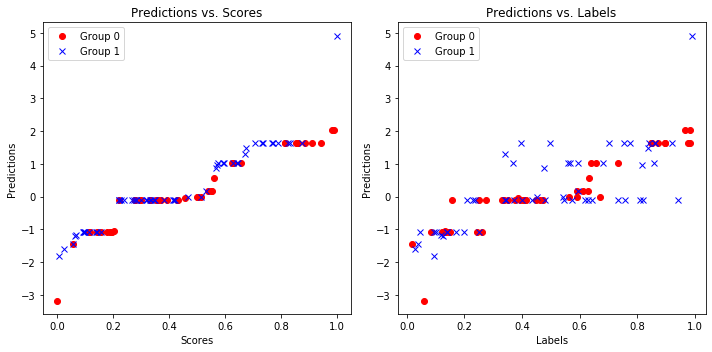

In [28]:
ff, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_scores(scores, predictions[best_iterate], groups, ax[0], 
            "Scores", "Predictions")
plot_scores(labels, predictions[best_iterate], groups, ax[1], 
            "Labels", "Predictions")
ff.tight_layout()

The monotone function flattens out portions of the scores in the middle range $[0.2, 0.8]$ (here the scores are noisy for group 1). This has the effect of introducing ties among the examples in this region, and thus improving the value of $Acc_{G_1 > G0}$, while lowering the $Acc_{G_0 > G1}$ value.